# Insurance company customers' segmentation
## Group project
### This notebook uses the *a2z_insurance.sas7bdat* dataset

(c) Vasco Jesus, Nuno António 2020-2021 - Rev. 2.01

## Dataset description

- **CustID**: numeric - customer ID
- **FirstPolYear**: numeric - year of the customer's first policy. Maybe considered the first year as a customer
- **BirthYear**: numeric - birth year of the customer. The current year of the database is 2016
- **EducDeg**: categorical - academic degree
- **MonthSal**: numerical - monthly gross salary (€)
- **GeoLivArea**: numerical - codes about the area of living. No additional information is available for these codes
- **Children**: numerical - indication if the customer has children (0: no, 1: yes)
- **CustMonVal**: numerical - customer monetary value (CMV). CMV = (annual profit from the customer) x (number of years since a customer) - (acquisition cost)
- **ClaimsRate**: numerical - claims rate. Amount paid by the insurance company (€)/Premiums(€) (in the last two years)
- **PremMotor**: numerical - premiums in the Line of Business (LOB) Motor (€)
- **PremHousehold**: numerical - premiums in the LOB Household (€)
- **PremHealth**: numerical - premiums in the LOB Health (€)
- **PremLife**: numerical - premiums in the LOB Life (€)
- **PremWork**: numerical - premiums in the LOB Work (€)

<br>NOTES about all Premiums:
- Annual premiums (2016)
- Negative premiums may manifest reversals occurred in the current year, paid in previous one(s)

## Group details
- Composed of three students. Groups of two are aceptable, but must be approved by instructors.
- Students can be from different theory and practical classes.

## Work description

### Overview
<p>You should organize into groups of up to 3 students, where you will assume the role of Data Mining/Analytic Consultant company. You are asked to develop a Customer Segmentation in such a way that it will be possible for the Marketing Department of an insurance company to understand all the different Customers’ Profiles better.</p>
<p>Employing the CRISP-DM process model, you are expected to define, describe and explain the clusters you chose. Invest time in reasoning how you want to do your clustering, possible approaches, and advantages or disadvantages of different decisions. Simultaneous, you should express the marketing approach you recommend for each cluster.</p>

### Deliverables
- Python source code (Jupyter notebook or .py files). Code should be commented to facilitate comprehension
- Report:
    - Maximum of 20 pages (excluding appendixes)
    - Minimum font size is 10
    - Should describe the main outputs according to CRISP-DM, including the brief description of the problem, methods, results, and their discussion


### Discussion
- To be done in the exam season with all group members present
- Slots of 15 minutes per group
- No presentation is required. Just start the discussion with your report and Python file(s) open


### Questions or additional informations
For any additional questions, don't hesitate to get in touch with the instructors of the practical classes. They will also act as the insurance company business/project stakeholders.

<br><br>
Good work or good luck ;)

## Initializations and data loading

In [1]:
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    """Remove rows with outliers below or above the predefined percentile thresholds

    Args:
        df (dataframe): dataframe object
        colList (string list): list with names of columns
        lowPercentile (float, optional): Rows with value below this threshold will be removed. Defaults to 0.05.
        highPercentile (float, optional): Rows with value above this threshold will be removed. Defaults to 0.95.
        verbose (bool, optional): Indication if it should give feedback on the percentiles. Defaults to False.

    Returns:
        dataframe: the dataframe with the rows removed.
    """
    # Identify percentiles
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)

    # Loop in each column
    for name in list(df[colList].columns):

        # Keep only rows that are inside the limits
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]

    return df

In [3]:
def one_hot(s, threshold,prefix):
    """Do one-hot encoding for categories above a threshold and create a dummy column for all others named "Other"

    Args:
        s (series): series to apply the transformation
        threshold (numerical): threshold above which a dummy column should be created (from 0 to 1, corresponding from 0 to 100%)
        prefix (string): prefix to assign to the created columns

    Returns:
        dataframe: dataframe with the applied transformations 
    """
    # Check dummies for the column
    d = pd.get_dummies(s)

    # Check if percentage is below threshold and act accordingly
    f = pd.value_counts(s, sort=False, normalize=True) < threshold
    if f.sum() == 0:
        newSeries=d
    else:
        newSeries=d.loc[:, ~f].join(d.loc[:, f].sum(1).rename('Other'))
    # Add the prefix and return the result    
    newSeries=newSeries.add_prefix(prefix)
    return newSeries

In [4]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [5]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

In [6]:

numerical = ['FirstPolYear','BirthYear','MonthSal','CustMonVal','ClaimsRate','PremMotor','PremHousehold','PremHealth','PremLife','PremWork']


In [7]:


# Loading the dataset and visualizing summary statistics
ds = pd.read_sas('a2z_insurance.sas7bdat', format='sas7bdat')



dsNumerical = ds[numerical]

describeDF = dsNumerical.describe(include='all').T

#data types
describeDF['dtype'] = ds.dtypes
#null count
describeDF['null count'] = ds.isnull().sum()

describeDF




,count,mean,std,min,25%,50%,75%,max,dtype,null count
FirstPolYear,10266.0,1991.062634,511.267913,1974.00,1980.00,1986.00,1992.0000,53784.00,float64,30
BirthYear,10279.0,1968.007783,19.709476,1028.00,1953.00,1968.00,1983.0000,2001.00,float64,17
MonthSal,10260.0,2506.667057,1157.449634,333.00,1706.00,2501.50,3290.2500,55215.00,float64,36
CustMonVal,10296.0,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89,float64,0
ClaimsRate,10296.0,0.742772,2.916964,0.00,0.39,0.72,0.9800,256.20,float64,0
PremMotor,10262.0,300.470252,211.914997,-4.11,190.59,298.61,408.3000,11604.42,float64,34
PremHousehold,10296.0,210.431192,352.595984,-75.00,49.45,132.80,290.0500,25048.80,float64,0
PremHealth,10253.0,171.580833,296.405976,-2.11,111.80,162.81,219.8200,28272.00,float64,43
PremLife,10192.0,41.855782,47.480632,-7.00,9.89,25.56,57.7900,398.30,float64,104
PremWork,10210.0,41.277514,51.513572,-12.00,10.67,25.67,56.7900,1988.70,float64,86


In [8]:
# Show top rows
ds.head()


,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [9]:
#check if id is unique
ds["CustID"].is_unique 

print(str(ds.shape[0]) + " unique users")

10296 unique users


In [10]:
#Identify the duplicate values
duplicated = ds[ds.duplicated(subset = ds.columns[1:])]
ds.shape[0]
duplicated

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
8013,8014.0,1987.0,1987.0,b'2 - High School',1912.0,4.0,1.0,290.61,0.58,202.37,177.25,306.39,63.90,-0.11
8121,8122.0,1977.0,1974.0,b'2 - High School',2204.0,4.0,1.0,-22.11,1.00,214.93,88.90,266.94,39.23,42.12
9553,9554.0,1986.0,1952.0,b'2 - High School',3900.0,4.0,0.0,-119.35,1.10,163.03,481.75,224.82,94.35,18.56


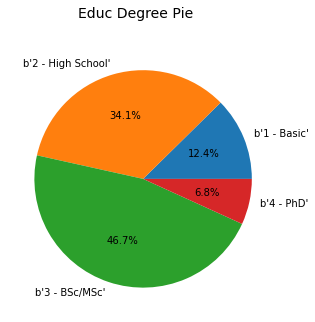

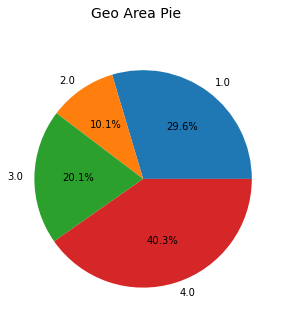

In [11]:
# PIE CHART

# Aggregate
tempEducDeg = ds.groupby('EducDeg').agg('count')

# Draw
fig, ax = plt.subplots(figsize=(8,5))
ax.pie(tempEducDeg.CustID.to_list(), labels=tempEducDeg.index.to_list(),
        autopct='%1.1f%%');
fig.suptitle("Educ Degree Pie", fontsize=plots_Title_fontSize);

# PIE CHART

# Aggregate
tempGeoArea = ds.groupby('GeoLivArea').agg('count')

# Draw
fig, ax = plt.subplots(figsize=(8,5))
ax.pie(tempGeoArea.CustID.to_list(), labels=tempGeoArea.index.to_list(),
        autopct='%1.1f%%');
fig.suptitle("Geo Area Pie", fontsize=plots_Title_fontSize);



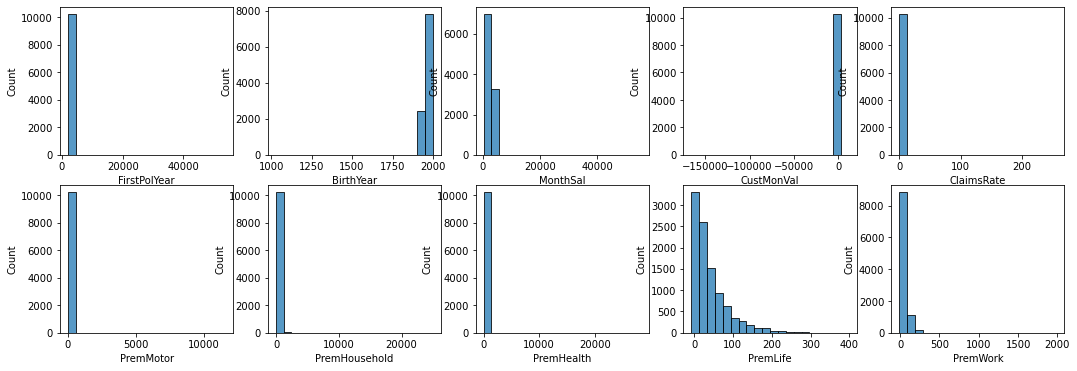

In [12]:
# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.histplot(data=ds,
                bins=20,
                 x=var,
                 ax=subplot,
                 kde=False)

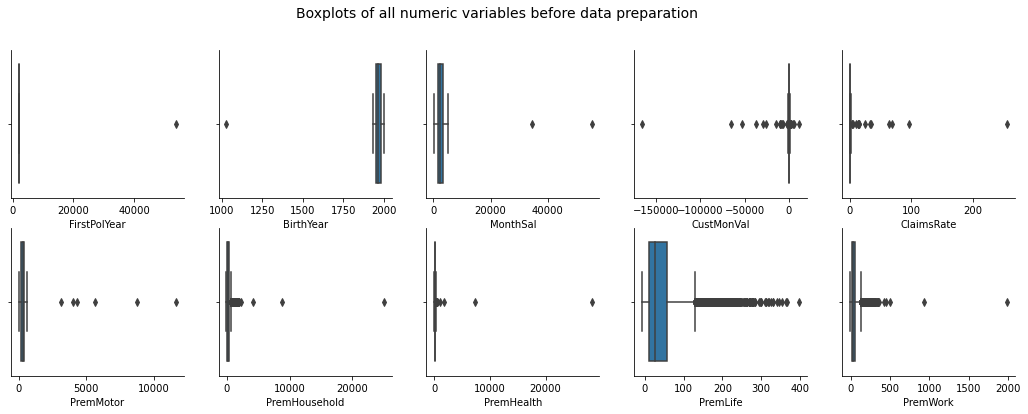

In [13]:

# BOXPLOT (ALL NUMERIC VARIABLES)


# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.boxplot(data=ds,
                 x=var,
                 ax=subplot)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Boxplots of all numeric variables before data preparation", fontsize=plots_Title_fontSize);

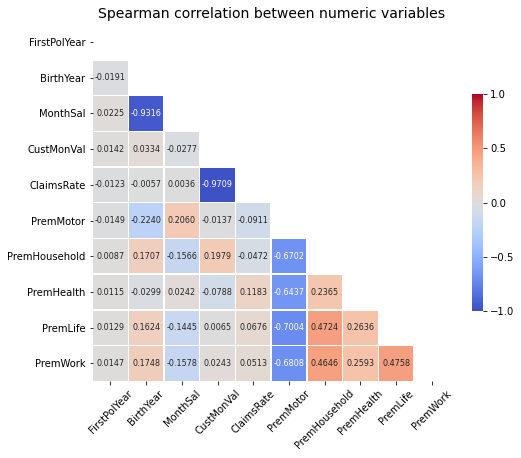

In [14]:
# CORRELATION

# Create correlation matrix
corr = ds[numerical].corr(method='spearman')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(8, 10))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.4f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman correlation between numeric variables", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

## Data Preparation

In [149]:

numerical = ['FirstPolYear','BirthYear','MonthSal','CustMonVal','ClaimsRate','PremMotor','PremHousehold','PremHealth','PremLife','PremWork']


In [150]:
##### Create a copy of the dataframe
copiedDs = ds.copy(deep=True)


## Unskew var

In [151]:
min_PremHousehold=copiedDs['PremHousehold'].min()
min_PremLife=copiedDs['PremLife'].min()
min_PremWork=copiedDs['PremWork'].min()
cols_min =[min_PremHousehold, min_PremLife, min_PremWork]
cols_min

# Somar o minimo valor de cada variavel +1
cols_log = ['PremHousehold','PremLife','PremWork']
for i in range(len(cols_log)):
    copiedDs[cols_log[i]]=copiedDs[cols_log[i]]+abs(copiedDs[cols_log[i]].min())+1

# Aplicar logaritmo
for c in cols_log:
    copiedDs[c] = np.log10(copiedDs[c])
    

#[-60.0, -6.0, -9.0]

## Missing Values

In [152]:
null_columns=copiedDs.columns[copiedDs.isnull().any()]
copiedDs[null_columns].isnull().sum()


FirstPolYear     30
BirthYear        17
EducDeg          17
MonthSal         36
GeoLivArea        1
Children         21
PremMotor        34
PremHealth       43
PremLife        104
PremWork         86
dtype: int64

In [153]:
#replace null of FirstPolYear for random year from our dataset

copiedDs_h=copiedDs[copiedDs['FirstPolYear'].isnull()]
for i in copiedDs_h.index: 
    copiedDs.at[i,'FirstPolYear']=np.random.randint(copiedDs['FirstPolYear'].min(),1998)

In [154]:
#replace null of FirstPolYear for random year from our dataset

copiedDs_h=copiedDs[copiedDs['BirthYear'].isnull()]
for i in copiedDs_h.index: 
    copiedDs.at[i,'BirthYear']=np.random.randint(copiedDs['BirthYear'].min(),copiedDs['BirthYear'].max())

In [155]:
#replace Nan for 0 assumning that 0 is a client that doesnt have that ensurance
copiedDs['PremLife'] = copiedDs['PremLife'].replace(np.nan,0)
copiedDs['PremMotor'] = copiedDs['PremMotor'].replace(np.nan,0)
copiedDs['PremWork'] = copiedDs['PremWork'].replace(np.nan,0)
copiedDs['PremHealth'] = copiedDs['PremHealth'].replace(np.nan,0)

#replace Nan for 0 assumning that 0 is a client that doesnt have childrens
copiedDs['Children'] = copiedDs['Children'].replace(np.nan,0)

#replace null of geoliv by the mod
copiedDs['GeoLivArea'] = copiedDs['GeoLivArea'].replace(np.nan,copiedDs['GeoLivArea'].mode()[0])

#replace null of EducDeg by the mod
copiedDs['EducDeg'] = copiedDs['EducDeg'].replace(np.nan,copiedDs['EducDeg'].mode()[0])

#replace   null of FirstPolYear for median
#copiedDs['FirstPolYear'] = copiedDs['FirstPolYear'].replace(np.nan,copiedDs['FirstPolYear'].mean())

#replace   null of CustMontVall for mean
copiedDs['MonthSal'] = copiedDs['MonthSal'].replace(np.nan,copiedDs['MonthSal'].mean())

#replace   null of ClaimsRate for mean
copiedDs['ClaimsRate'] = copiedDs['ClaimsRate'].replace(np.nan,copiedDs['ClaimsRate'].mean())

#replace   null of ClaimsRate for mean
copiedDs['CustMonVal'] = copiedDs['CustMonVal'].replace(np.nan,copiedDs['CustMonVal'].mean())

#PremHousehold
#copiedDs.drop(copiedDs[copiedDs['PremHousehold'] >= 4130.70].index, inplace = True)



In [156]:
copiedDs[(copiedDs['PremMotor'].isnull()) & (copiedDs['PremHousehold'] == 0) & (copiedDs['PremHealth'].isnull()) &  (copiedDs['PremLife'].isnull()) & (copiedDs['PremWork'].isnull())]

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork


In [157]:
copiedDs[copiedDs['BirthYear'].isnull()==True].count()

CustID           0
FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

## Outliers

In [158]:
#remove birthday = 1028
copiedDs.drop(copiedDs[(copiedDs['BirthYear'] < 1935) | (copiedDs['BirthYear'] >2001)].index, inplace = True)

#remove birthday = 53784.00
copiedDs.drop(copiedDs[copiedDs['FirstPolYear'] == 53784.00].index, inplace = True)

#remove MonthSal > 5021.0
copiedDs.drop(copiedDs[copiedDs['MonthSal'] > 5021.0].index, inplace = True)

#remove custMonthVal > 11875.89 e <-490
copiedDs.drop(copiedDs[(copiedDs['CustMonVal'] > 1000) | (copiedDs['CustMonVal']  < -490)].index, inplace = True)

#remove claimsRate > 96 
copiedDs.drop(copiedDs[copiedDs['ClaimsRate'] >= 96.0].index, inplace = True)

#PremWork
copiedDs.drop(copiedDs[(copiedDs['PremMotor'] > 585.22) | (copiedDs['PremMotor'] < 50)].index, inplace = True)

#PremHealth
copiedDs.drop(copiedDs[copiedDs['PremHealth'] > 400].index, inplace = True)


#copiedDs.drop(copiedDs[copiedDs['FirstPolYear'].isnull() & copiedDs['BirthYear'].isnull() ].index, inplace = True)

#remove clients that doesnt have prems
copiedDs.drop(copiedDs[(copiedDs['PremMotor'].isnull()) & (copiedDs['PremHousehold'] == 0) & (copiedDs['PremHealth'].isnull()) &  (copiedDs['PremLife'].isnull()) &  (copiedDs['PremWork'].isnull())].index, inplace = True)

In [159]:
# Remove outliers by algorithm
copiedDs = removeOutliers(copiedDs, colList=cols_log , lowPercentile=0.02, highPercentile=0.98, verbose=True)    


      PremHousehold  PremLife  PremWork
0.02       1.483587  0.301030  0.698970
0.98       2.922747  2.241828  2.239948


In [160]:
copiedDs.shape

(8774, 14)

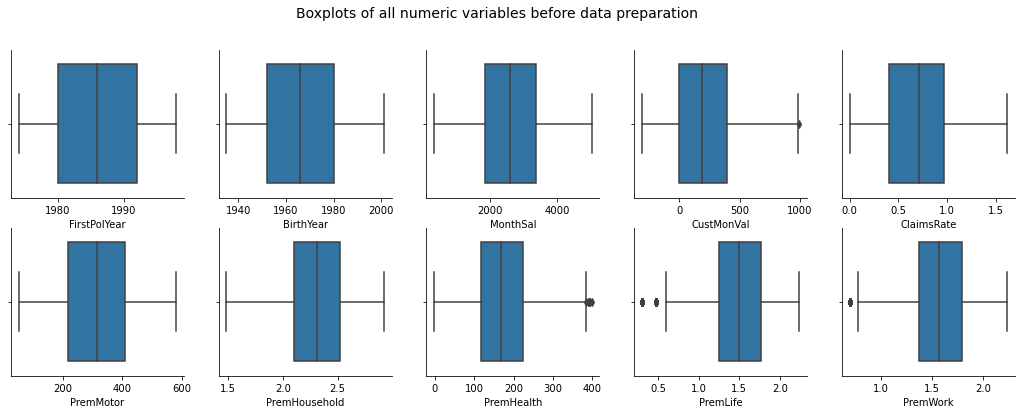

In [161]:
# BOXPLOT (ALL NUMERIC VARIABLES)

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(copiedDs[numerical], ax.flatten()):
    g = sns.boxplot(data=copiedDs,
                 x=var,
                 ax=subplot)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Boxplots of all numeric variables before data preparation", fontsize=plots_Title_fontSize);

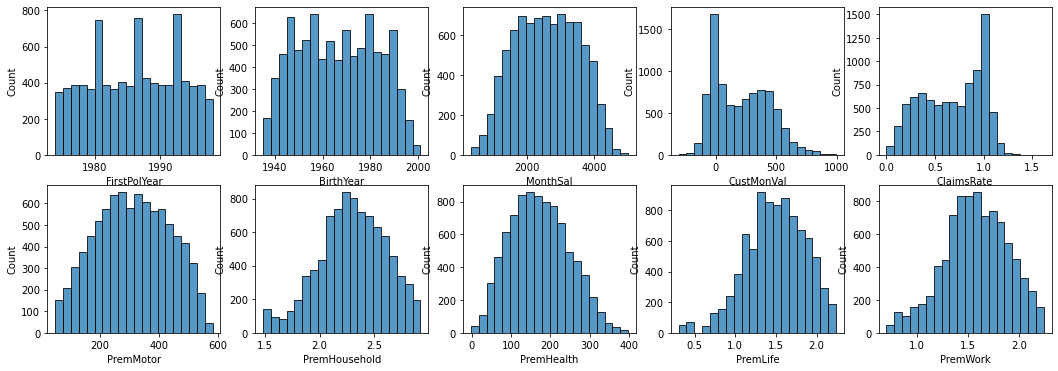

In [162]:
# Draw 
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(copiedDs[numerical], ax.flatten()):
    g = sns.histplot(data=copiedDs,
                bins=20,
                 x=var,
                 ax=subplot,
                 kde=False)

In [163]:
copiedDs.shape

(8774, 14)

## Create New Vars 

In [164]:
copiedDs['Profit'] = (copiedDs['CustMonVal'] + copiedDs['PremMotor'] + copiedDs['PremHousehold'] + copiedDs['PremHealth'] + copiedDs['PremLife']+ copiedDs['PremWork']) / (2016 - copiedDs['FirstPolYear'])

#Sum of all prems
copiedDs['TotalPrems'] = copiedDs['CustMonVal'] + copiedDs['PremMotor'] + copiedDs['PremHousehold'] + copiedDs['PremHealth'] + copiedDs['PremLife']+ copiedDs['PremWork']

copiedDs['YearsAsCust'] = (2016 - copiedDs['FirstPolYear'])

copiedDs['IsProfit'] = 0

copiedDs['AnualSal']= copiedDs['MonthSal']*12

copiedDs.loc[copiedDs.CustMonVal > 0 ,'IsProfit'] = 1

copiedDs['GeoLivAreaNumb'] =  copiedDs['GeoLivArea']

copiedDs['EducDegNum'] =  copiedDs['EducDeg']

copiedDs['EducDegNum'].replace(to_replace=[b'1 - Basic', b'2 - High School', b'3 - BSc/MSc', b'4 - PhD'], value=[1, 2, 3, 4], inplace=True)

copiedDs['EducCat'] = np.where((copiedDs['EducDegNum']== 3)|
                               (copiedDs['EducDegNum']== 4),1,0)
 
copiedDs["Basic_High_School"] = 0
copiedDs["BSc_MSc_PhD"] = 0

copiedDs.loc[(copiedDs.EducDeg == b'1 - Basic') | (copiedDs.EducDeg == b'2 - High School'),'Basic_High_School'] = 1
copiedDs.loc[(copiedDs.EducDeg == b'3 - BSc/MSc') | (copiedDs.EducDeg == b'4 - PhD'),'BSc_MSc_PhD'] = 1    
    
         
# One hot encoding of all categories above 15% - all others categories to "Other"
cols = ['EducDeg','GeoLivArea']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
copiedDs = ce_one_hot.fit_transform(copiedDs)



copiedDs = copiedDs.rename({"EducDeg_b'2 - High School'" : 'High_School', "EducDeg_b'3 - BSc/MSc'": 'BSc_MSc',"EducDeg_b'1 - Basic'":'Basic', "EducDeg_b'4 - PhD'" : 'PhD'}, axis='columns')
copiedDs = copiedDs.rename({"GeoLivArea_1.0" : 'Area1', "GeoLivArea_2.0": 'Area2',"GeoLivArea_3.0":'Area3', "GeoLivArea_4.0" : 'Area4'}, axis='columns')
  
copiedDs.describe().T

,count,mean,std,min,25%,50%,75%,max
CustID,8774.0,5129.786642,2964.729096,1.000000,2563.250000,5124.000000,7682.500000,10296.000000
FirstPolYear,8774.0,1986.035218,6.587036,1974.000000,1980.000000,1986.000000,1992.000000,1998.000000
BirthYear,8774.0,1966.250627,16.490072,1935.000000,1952.000000,1966.000000,1980.000000,2001.000000
High_School,8774.0,0.345111,0.475431,0.000000,0.000000,0.000000,1.000000,1.000000
Basic,8774.0,0.085822,0.280117,0.000000,0.000000,0.000000,0.000000,1.000000
BSc_MSc,8774.0,0.498404,0.500026,0.000000,0.000000,0.000000,1.000000,1.000000
PhD,8774.0,0.070663,0.256276,0.000000,0.000000,0.000000,0.000000,1.000000
MonthSal,8774.0,2597.181902,939.710819,333.000000,1842.250000,2594.000000,3355.000000,5021.000000
Area1,8774.0,0.294393,0.455795,0.000000,0.000000,0.000000,1.000000,1.000000
Area3,8774.0,0.200479,0.400381,0.000000,0.000000,0.000000,0.000000,1.000000


In [165]:
# Bin the PremWork
#X['age_bins'] = pd.cut(x=X['age'], bins=[0, 19, 29, 39, 49, 59, 99], labels=['<20','20-29','30-39','40-49','50-59','>=60'])
copiedDs['PremWork_Bins'] = pd.cut(x=copiedDs['PremWork'], bins=[0, 1.1, 1.3, 1.5,1.7,1.9,2.1], labels=['<1.0','1.0-1.1','1.2-1.3','1.4-1.5','1.5-1.6','>=2'])
copiedDs['CustMonVal_Bins'] = pd.cut(x=copiedDs['CustMonVal'], bins=[-200,0, 200, 400, 600,800,1000], labels=['<0','0-199','200-399','400-599','600-799','>=800'])

cols = ['PremWork_Bins','CustMonVal_Bins']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
copiedDs = ce_one_hot.fit_transform(copiedDs)

<AxesSubplot:xlabel='CustMonVal', ylabel='ClaimsRate'>

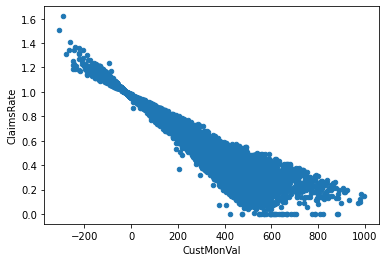

In [166]:
copiedDs.plot(x='CustMonVal', y='ClaimsRate', kind='scatter')

<AxesSubplot:xlabel='MonthSal', ylabel='BirthYear'>

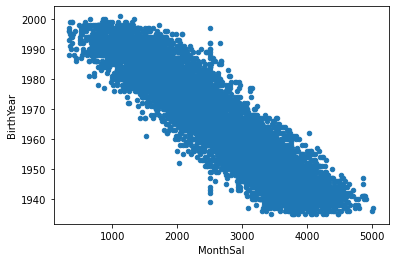

In [167]:
copiedDs.plot(x='MonthSal', y='BirthYear', kind='scatter')

<AxesSubplot:>

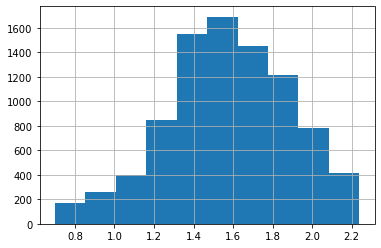

In [168]:
copiedDs['PremWork'].hist()

In [169]:
copiedDs['PremWork'].max()

2.238397413181271

<AxesSubplot:>

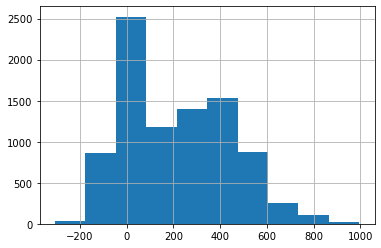

In [170]:
copiedDs['CustMonVal'].hist()

In [228]:

# 'Basic','High_School','BSc_MSc','PhD' 
# 'Basic_High_School','BSc_MSc_PhD'
# 'EducDegNum'
#'PremMotor','PremHousehold','PremHealth','PremLife','AnualSal','FirstPolYear','CustMonVal','PremWork'
#'PremWork_Bins_<1.0','PremWork_Bins_1.0-1.1','PremWork_Bins_1.2-1.3','PremWork_Bins_1.4-1.5','PremWork_Bins_1.5-1.6','PremWork_Bins_>=2'
#productNumb = ['Basic','High_School','BSc_MSc','PhD','CustMonVal','TotalPrems','AnualSal']
#productNumb = ['EducDegNum','CustMonVal_Bins_<0','CustMonVal_Bins_0-199','CustMonVal_Bins_200-399','CustMonVal_Bins_400-599','CustMonVal_Bins_600-799','CustMonVal_Bins_>=800','CustMonVal_Bins_nan' ,'AnualSal','FirstPolYear','CustMonVal']

productNumb = ['Basic_High_School','BSc_MSc_PhD','FirstPolYear','Children','CustMonVal','AnualSal','PremMotor','PremHousehold','PremHealth','PremLife','PremWork']

#productNumb = ['Basic_High_School','BSc_MSc_PhD','Children','CustMonVal','PremMotor','PremHousehold','PremHealth','PremLife','PremWork']


#productNumb = ['Basic','High_School','BSc_MSc','PhD','Children','YearsAsCust','AnualSal','PremMotor','PremHousehold','PremHealth','PremLife','PremWork']

In [229]:
productDs = copiedDs[productNumb]

In [230]:
# Get a copy of the dataframe before normalization for results' analysis

beforeNormProductDs = productDs.copy(deep=True)

In [231]:
# Normalize all columns
# MinMax scaler returns an array, so the dataframe must be recreated
productDs = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(productDs.values), columns=productDs.columns,index=productDs.index)

# Product

In [232]:
# Check dataframe structure and statistics after all transformations
print(productDs.shape)
productDs.describe(include='all').T

(8774, 11)


,count,mean,std,min,25%,50%,75%,max
Basic_High_School,8774.0,0.430932,0.495235,0.0,0.000000,0.000000,1.000000,1.0
BSc_MSc_PhD,8774.0,0.569068,0.495235,0.0,0.000000,1.000000,1.000000,1.0
FirstPolYear,8774.0,0.501467,0.274460,0.0,0.250000,0.500000,0.750000,1.0
Children,8774.0,0.703100,0.456918,0.0,0.000000,1.000000,1.000000,1.0
CustMonVal,8774.0,0.397575,0.174755,0.0,0.232492,0.382388,0.538259,1.0
AnualSal,8774.0,0.482974,0.200450,0.0,0.321939,0.482295,0.644625,1.0
PremMotor,8774.0,0.493264,0.230426,0.0,0.314368,0.495088,0.676014,1.0
PremHousehold,8774.0,0.566171,0.212995,0.0,0.427304,0.572935,0.721167,1.0
PremHealth,8774.0,0.435685,0.185370,0.0,0.296889,0.425497,0.564366,1.0
PremLife,8774.0,0.614399,0.188389,0.0,0.490608,0.618489,0.754010,1.0


In [233]:
# Fit the PCA algorithm to data 
pca = PCA().fit(productDs)

# Show the variance per component
pcaevr = ['{:f}'.format(item) for item in pca.explained_variance_ratio_]
pcaDF = pd.DataFrame({'Component': range(1, len(productDs.columns)+1),
                      'Variance explained': pcaevr,
                      'Cumulative variance explained': np.cumsum(pca.explained_variance_ratio_)})
pcaDF

,Component,Variance explained,Cumulative variance explained
0,1,0.485151,0.485151
1,2,0.222648,0.707799
2,3,0.093603,0.801402
3,4,0.071372,0.872774
4,5,0.036269,0.909043
5,6,0.025282,0.934325
6,7,0.023160,0.957484
7,8,0.020657,0.978141
8,9,0.019659,0.997800
9,10,0.002200,1.000000


Text(0.5, 1.0, 'Explained variance by components')

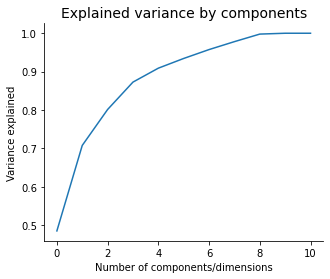

In [234]:
# Plot the cumulative explained variance

# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Decoration
sns.despine()
plt.xlabel('Number of components/dimensions')
plt.ylabel('Variance explained')
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.title('Explained variance by components', fontsize=plots_Title_fontSize)

#  Modeling

In [267]:
# Apply the dimension reduction to the dataset (for 7 components)
pca_reduced = PCA(n_components = 8)
pca_reduced.fit(productDs)
X_pca_reduced = pca_reduced.transform(productDs) 
print(X_pca_reduced.shape)

(8774, 8)


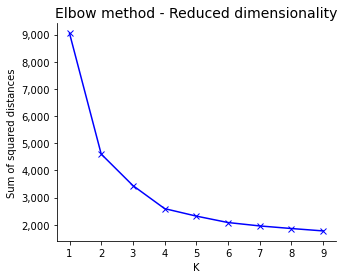

In [268]:
# Select K based on the sum of squared distances - Elbow method
ssd = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=123)
    km = km.fit(X_pca_reduced)
    ssd.append(km.inertia_)
    
# Show Results
# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(K, ssd, 'bx-')
# Decoration
sns.despine()
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.rc('axes', labelsize=subPlots_label_fontSize)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('Elbow method - Reduced dimensionality', fontsize=plots_Title_fontSize);

In [269]:
#### Apply the K-Means for K=4
K=4
kmeans = KMeans(n_clusters=K, random_state=123)
allDistances = kmeans.fit_transform(X_pca_reduced)
y_kmeans = kmeans.predict(X_pca_reduced)

## Evaluate Cluster Quality

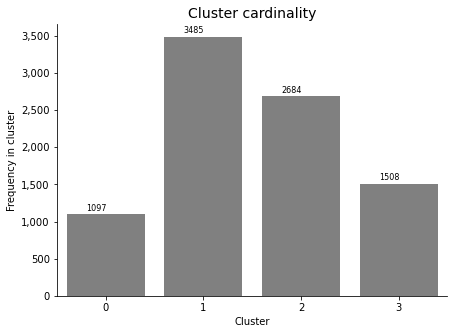

In [270]:
# Plot clusters cardinality 

# Count observations per cluster
freqByCluster = beforeNormProductDs.groupby(y_kmeans).size()

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.countplot(x=y_kmeans, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(freqByCluster):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster cardinality", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Frequency in cluster")
plt.rc('axes', labelsize=subPlots_label_fontSize)

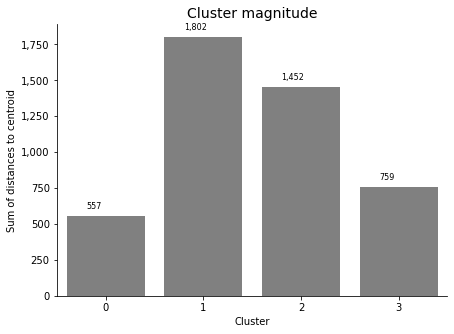

In [271]:
# Plot clusters magnitude

# Compute Magnitude
productDs['distanceToCentroid'] = np.min(allDistances,axis=1)
magnitude = productDs['distanceToCentroid'].groupby(y_kmeans).sum()
productDs = productDs.drop(columns=['distanceToCentroid'])

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.barplot(x=magnitude.index, y=magnitude.values, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(magnitude):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data:,.0f}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Sum of distances to centroid")
plt.rc('axes', labelsize=subPlots_label_fontSize)

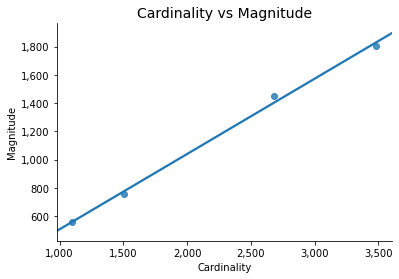

In [272]:
# Plot cardinality vs magnitude

# Draw
fig, ax = plt.subplots(figsize=(6,4))
g = sns.regplot(x=freqByCluster, y=magnitude, scatter=True, seed=123,truncate=False, ci=None)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Cardinality vs Magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cardinality")
plt.ylabel("Magnitude")
plt.rc('axes', labelsize=subPlots_label_fontSize)

## Clusters Analysis

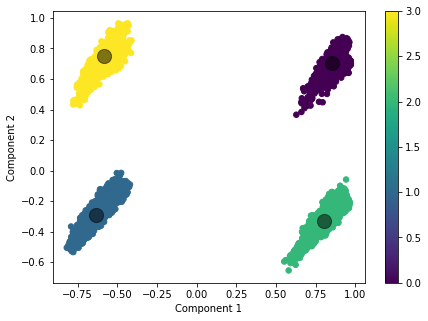

In [273]:
# Scatter plot of the two Principal Components by cluster to see if there is any pattern

# Draw
fig, ax = plt.subplots(figsize=(7,5))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y_kmeans, s=30, cmap='viridis')
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# Decoration
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

In [274]:
# Fit the PCA algorithm to data 
pca = PCA().fit(productDs)

# Show the variance per component
pcaevr = ['{:f}'.format(item) for item in pca.explained_variance_ratio_]
pcaDF = pd.DataFrame({'Component': range(1, len(productDs.columns)+1),
                      'Variance explained': pcaevr,
                      'Cumulative variance explained': np.cumsum(pca.explained_variance_ratio_)})
pcaDF

,Component,Variance explained,Cumulative variance explained
0,1,0.485151,0.485151
1,2,0.222648,0.707799
2,3,0.093603,0.801402
3,4,0.071372,0.872774
4,5,0.036269,0.909043
5,6,0.025282,0.934325
6,7,0.023160,0.957484
7,8,0.020657,0.978141
8,9,0.019659,0.997800
9,10,0.002200,1.000000


In [275]:
# Create a dataframe with the weights per component
wheightsDF = pd.DataFrame(pca.components_,columns=productDs.columns)
wheightsDF

,Basic_High_School,BSc_MSc_PhD,FirstPolYear,Children,CustMonVal,AnualSal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,0.688245,-0.688245,2.229008e-03,-1.376240e-02,4.251749e-03,-1.713855e-02,-1.337185e-01,1.053828e-01,4.235770e-02,9.973296e-02,1.067859e-01
1,-0.053029,0.053029,1.826492e-02,-9.235926e-01,-5.362727e-03,2.204303e-01,-1.985248e-01,1.033743e-01,1.524463e-01,9.948956e-02,9.573071e-02
2,0.148062,-0.148062,-2.981382e-02,-2.518790e-01,-3.377939e-02,2.502092e-01,5.652834e-01,-3.943318e-01,-3.385452e-01,-3.188672e-01,-3.697911e-01
3,-0.003423,0.003423,-9.990904e-01,-1.478191e-02,-1.077426e-02,-2.300128e-02,-1.921723e-02,8.611869e-03,1.591743e-02,1.078879e-02,1.086271e-02
4,0.016002,-0.016002,1.330669e-02,2.632900e-02,-7.238984e-01,-6.025746e-02,-1.510327e-01,-5.379554e-01,3.969785e-01,2.502797e-02,-2.307577e-02
5,0.032207,-0.032207,1.197491e-02,-1.551555e-01,2.527165e-01,-6.060190e-01,-7.504661e-02,3.432088e-02,3.790498e-01,-2.784559e-01,-5.608545e-01
6,-0.006702,0.006702,1.417818e-02,-2.300818e-01,-9.518395e-03,-6.886107e-01,1.400803e-01,-2.612336e-01,-3.820338e-01,4.803830e-02,4.861824e-01
7,0.013910,-0.013910,-6.252731e-03,6.095871e-02,3.579843e-01,1.801349e-01,-8.733507e-02,-2.843152e-01,3.250051e-01,-6.390447e-01,4.824808e-01
8,-0.000205,0.000205,5.113759e-03,-3.911726e-02,-5.315128e-01,-9.085264e-02,8.426122e-02,5.894285e-01,-1.073152e-01,-5.745997e-01,1.071270e-01
9,-0.006341,0.006341,-2.035142e-03,1.324926e-02,-7.227781e-03,4.696358e-02,-7.483315e-01,-1.885695e-01,-5.438147e-01,-2.436140e-01,-2.164289e-01


In [276]:
# Study the weights of component 15
comp = abs(wheightsDF.iloc[10])  ## index 14 is component 15
comp = comp.sort_values(ascending=False)
comp

BSc_MSc_PhD          7.071068e-01
Basic_High_School    7.071068e-01
PremHealth           6.459196e-17
FirstPolYear         4.506031e-17
PremWork             3.264608e-17
PremMotor            2.999341e-17
PremHousehold        2.853484e-17
PremLife             2.598969e-17
Children             2.199994e-17
CustMonVal           1.444747e-17
AnualSal             1.168591e-18
Name: 10, dtype: float64

In [277]:
# Check the mean values of each cluster for each features
top_features = comp[:11].index
clustersMeanDF = pd.DataFrame(beforeNormProductDs[top_features].groupby(y_kmeans).mean(),columns=top_features)
clustersMeanDF = clustersMeanDF.transpose()

2.2982971846248104


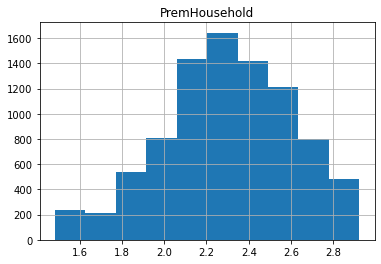

In [278]:
copiedDs.hist('PremHousehold')

print(copiedDs['PremHousehold'].mean())

In [279]:
# Check the max values of each cluster for each features
top_features = comp[:11].index
clustersMaxDF = pd.DataFrame(beforeNormProductDs[top_features].groupby(y_kmeans).max(),columns=top_features)
clustersMaxDF = clustersMaxDF.transpose()

In [280]:
# Check the min values of each cluster for each features
top_features = comp[:11].index
clustersMinDF = pd.DataFrame(beforeNormProductDs[top_features].groupby(y_kmeans).min(),columns=top_features)
clustersMinDF = clustersMinDF.transpose()

In [281]:
# Check the median values of each cluster for each features
top_features = comp[:11].index
clustersMedianDF = pd.DataFrame(beforeNormProductDs[top_features].groupby(y_kmeans).median(),columns=top_features)
clustersMedianDF = clustersMedianDF.transpose()

clustersMedianDF

,0,1,2,3
BSc_MSc_PhD,0.000000,1.000000,0.000000,1.000000
Basic_High_School,1.000000,0.000000,1.000000,0.000000
PremHealth,207.260000,143.250000,164.810000,201.205000
FirstPolYear,1987.000000,1986.000000,1986.000000,1986.000000
PremWork,1.780605,1.460748,1.668013,1.562352
PremMotor,202.150000,380.850000,282.165000,286.610000
PremHousehold,2.508058,2.203848,2.378034,2.300813
PremLife,1.755951,1.355452,1.616370,1.500648
Children,0.000000,1.000000,1.000000,0.000000
CustMonVal,186.710000,198.810000,185.545000,194.765000


In [282]:
clustersMedianDF = clustersMedianDF.rename({0 : 'Med0', 1: 'Med1',2:'Med2', 3 : 'Med3'}, axis='columns')
clustersMeanDF = clustersMeanDF.rename({0 : 'Mean0', 1: 'Mean1',2:'Mean2', 3 : 'Mean3'}, axis='columns')
clustersMaxDF = clustersMaxDF.rename({0 : 'Max0', 1: 'Max1',2:'Max2', 3 : 'Max3'}, axis='columns')
clustersMinDF = clustersMinDF.rename({0 : 'Min0', 1: 'Min1',2:'Min2', 3 : 'Min3'}, axis='columns')


In [283]:
dfs = pd.DataFrame()

In [284]:
dfs['Med0'] = clustersMedianDF['Med0'];
dfs['Mean0'] = clustersMeanDF['Mean0'];
dfs['Max0'] = clustersMaxDF['Max0'];
dfs['Min0'] = clustersMinDF['Min0'];

dfs['Med1'] = clustersMedianDF['Med1'];
dfs['Mean1'] = clustersMeanDF['Mean1'];
dfs['Max1'] = clustersMaxDF['Max1'];
dfs['Min1'] = clustersMinDF['Min1'];

dfs['Med2'] = clustersMedianDF['Med2'];
dfs['Mean2'] = clustersMeanDF['Mean2'];
dfs['Max2'] = clustersMaxDF['Max2'];
dfs['Min2'] = clustersMinDF['Min2'];

dfs['Med3'] = clustersMedianDF['Med3'];
dfs['Mean3'] = clustersMeanDF['Mean3'];
dfs['Max3'] = clustersMaxDF['Max3'];
dfs['Min3'] = clustersMinDF['Min3'];

In [285]:
dfs.T

,BSc_MSc_PhD,Basic_High_School,PremHealth,FirstPolYear,PremWork,PremMotor,PremHousehold,PremLife,Children,CustMonVal,AnualSal
Med0,0.0,1.0,207.260000,1987.000000,1.780605,202.150000,2.508058,1.755951,0.0,186.710000,42108.000000
Mean0,0.0,1.0,207.178213,1986.253418,1.753718,214.530620,2.475508,1.713088,0.0,216.513373,39216.926179
Max0,0.0,1.0,393.740000,1998.000000,2.238397,578.330000,2.917925,2.240624,0.0,984.400000,60252.000000
Min0,0.0,1.0,0.000000,1974.000000,0.698970,51.900000,1.483587,0.301030,0.0,-280.160000,4092.000000
Med1,1.0,0.0,143.250000,1986.000000,1.460748,380.850000,2.203848,1.355452,1.0,198.810000,27468.000000
Mean1,1.0,0.0,150.788729,1985.944046,1.463540,369.226080,2.197730,1.353844,1.0,213.272000,27788.325989
Max1,1.0,0.0,389.740000,1998.000000,2.230526,581.330000,2.922570,2.240350,1.0,995.740000,58596.000000
Min1,1.0,0.0,-2.110000,1974.000000,0.698970,50.900000,1.483587,0.301030,1.0,-264.490000,4380.000000
Med2,0.0,1.0,164.810000,1986.000000,1.668013,282.165000,2.378034,1.616370,1.0,185.545000,26760.000000
Mean2,0.0,1.0,169.698499,1985.976900,1.652033,288.491744,2.365643,1.585243,1.0,212.514419,26862.912087


In [286]:
dfs[['Med0','Min0','Mean0','Max0']]

,Med0,Min0,Mean0,Max0
BSc_MSc_PhD,0.000000,0.000000,0.000000,0.000000
Basic_High_School,1.000000,1.000000,1.000000,1.000000
PremHealth,207.260000,0.000000,207.178213,393.740000
FirstPolYear,1987.000000,1974.000000,1986.253418,1998.000000
PremWork,1.780605,0.698970,1.753718,2.238397
PremMotor,202.150000,51.900000,214.530620,578.330000
PremHousehold,2.508058,1.483587,2.475508,2.917925
PremLife,1.755951,0.301030,1.713088,2.240624
Children,0.000000,0.000000,0.000000,0.000000
CustMonVal,186.710000,-280.160000,216.513373,984.400000


In [287]:
dfs[['Med1','Min1','Mean1','Max1']]

,Med1,Min1,Mean1,Max1
BSc_MSc_PhD,1.000000,1.000000,1.000000,1.000000
Basic_High_School,0.000000,0.000000,0.000000,0.000000
PremHealth,143.250000,-2.110000,150.788729,389.740000
FirstPolYear,1986.000000,1974.000000,1985.944046,1998.000000
PremWork,1.460748,0.698970,1.463540,2.230526
PremMotor,380.850000,50.900000,369.226080,581.330000
PremHousehold,2.203848,1.483587,2.197730,2.922570
PremLife,1.355452,0.301030,1.353844,2.240350
Children,1.000000,1.000000,1.000000,1.000000
CustMonVal,198.810000,-264.490000,213.272000,995.740000


In [288]:
dfs[['Med2','Min2','Mean2','Max2']]

,Med2,Min2,Mean2,Max2
BSc_MSc_PhD,0.000000,0.000000,0.000000,0.000000
Basic_High_School,1.000000,1.000000,1.000000,1.000000
PremHealth,164.810000,0.000000,169.698499,398.410000
FirstPolYear,1986.000000,1974.000000,1985.976900,1998.000000
PremWork,1.668013,0.698970,1.652033,2.238121
PremMotor,282.165000,50.010000,288.491744,563.550000
PremHousehold,2.378034,1.483587,2.365643,2.922284
PremLife,1.616370,0.301030,1.585243,2.240350
Children,1.000000,1.000000,1.000000,1.000000
CustMonVal,185.545000,-307.270000,212.514419,979.970000


In [289]:
dfs[['Med3','Min3','Mean3','Max3']]

,Med3,Min3,Mean3,Max3
BSc_MSc_PhD,1.000000,1.000000,1.000000,1.000000
Basic_High_School,0.000000,0.000000,0.000000,0.000000
PremHealth,201.205000,0.000000,201.797613,390.740000
FirstPolYear,1986.000000,1974.000000,1986.190981,1998.000000
PremWork,1.562352,0.698970,1.549768,2.225387
PremMotor,286.610000,54.010000,293.023906,564.440000
PremHousehold,2.300813,1.483587,2.281932,2.904310
PremLife,1.500648,0.301030,1.488645,2.238121
Children,0.000000,0.000000,0.000000,0.000000
CustMonVal,194.765000,-245.150000,197.726711,890.380000
